In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data
import torch.nn.functional as F

from torch.autograd import Variable
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

from tkmodel.TwoCUM_copy import TwoCUMfittingConc
from tkmodel.TwoCUM_copy import TwoCUM

In [2]:
E_list_uterus = np.load('data/E_list_uterus.npy')

Fp_list_uterus = np.load('data/Fp_list_uterus.npy')

vp_list_uterus = np.load('data/vp_list_uterus.npy')



In [3]:
def get_best_distribution(data):
    dist_names = ["norm", "exponweib", "weibull_max", "weibull_min", "pareto", "genextreme", "halfnorm"]
    dist_results = []
    params = {}
    for dist_name in dist_names:
        dist = getattr(st, dist_name)
        param = dist.fit(data)

        params[dist_name] = param
        # Applying the Kolmogorov-Smirnov test
        D, p = st.kstest(data, dist_name, args=param)
        print("p value for "+dist_name+" = "+str(p))
        dist_results.append((dist_name, p))

    # select the best fitted distribution
    best_dist, best_p = (max(dist_results, key=lambda item: item[1]))
    # store the name of the best fit and its p value

    print("Best fitting distribution: "+str(best_dist))
    print("Best p value: "+ str(best_p))
    print("Parameters for the best fit: "+ str(params[best_dist]))

    return best_dist, best_p, params[best_dist]

In [4]:
print(E_list_uterus.size)
print(E_list_uterus[E_list_uterus < 0.001].size)
print(E_list_uterus[E_list_uterus < 0.001].size/E_list_uterus.size)





best_dist, best_p, params = get_best_distribution(E_list_uterus[E_list_uterus > 0.001])



905
85
0.09392265193370165
p value for norm = 4.0590787134284194e-05
p value for exponweib = 0.012444182595649259
p value for weibull_max = 3.500895592276253e-07
p value for weibull_min = 3.3025901126512923e-05
p value for pareto = 4.743509077861746e-35
p value for genextreme = 0.007720600168214746
p value for halfnorm = 1.6492214427723222e-15
Best fitting distribution: exponweib
Best p value: 0.012444182595649259
Parameters for the best fit: (69.70266807226483, 1.0792465008741048, -0.23357477054649745, 0.08955766184221467)


/usr/lib/python3/dist-packages/scipy/stats/_distn_infrastructure.py:2381: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


905 905


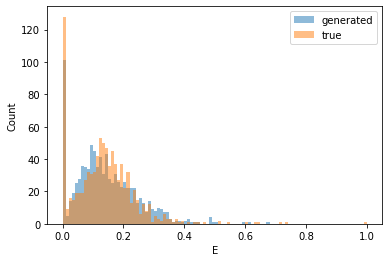

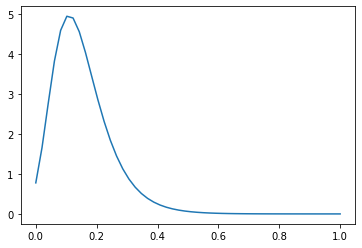

<Figure size 432x288 with 0 Axes>

In [5]:

def E_distribution(num):
    p = 0.09392265193370165
    params = (69.70266807226483, 1.0792465008741048, -0.23357477054649745, 0.08955766184221467)
    start_nums = int(p*num)
    
    start = np.random.uniform(low = 0, high= 0.001, size = start_nums)
    
    dist_num = num - start_nums
    gen_data_Fp = st.exponweib.rvs(params[0], params[1], params[2], params[3], size=dist_num)
    gen_data_Fp = np.array(gen_data_Fp)
    
    true_dist = np.concatenate((start, gen_data_Fp), axis=None)
    
    true_dist[true_dist < 0] = 0.0001

    
    
    return true_dist

gen_data = E_distribution(E_list_uterus.size)
print(gen_data.size, E_list_uterus.size)

plt.hist(gen_data, bins = 100, label='generated', alpha = 0.5, range=[0, 1])
plt.hist(E_list_uterus, bins = 100, label = 'true', alpha = 0.5, range=[0, 1])
plt.xlabel('E')
plt.ylabel('Count')
plt.legend()
plt.savefig('plots/E_dist')
plt.show()
plt.clf()

params = (69.70266807226483, 1.0792465008741048, -0.23357477054649745, 0.08955766184221467)
a, c, loc, scale = params
x = np.linspace(0,1)
plt.plot(x, st.exponweib.pdf(x, params[0], params[1], params[2], params[3]))
plt.show()
plt.clf()


In [6]:
print(Fp_list_uterus[Fp_list_uterus < 0.0005].size/Fp_list_uterus.size)
print(Fp_list_uterus.size)


best_dist, best_p, params = get_best_distribution(Fp_list_uterus[Fp_list_uterus > 0.0005])



0.11823204419889503
905
p value for norm = 5.749549199044708e-17
p value for exponweib = 4.008132593902139e-160


/usr/lib/python3/dist-packages/scipy/stats/_continuous_distns.py:1468: RuntimeWarning: invalid value encountered in add
  logp = (np.log(a) + np.log(c) + sc.xlogy(a - 1.0, exm1c) +


p value for weibull_max = 7.043682252498724e-05
p value for weibull_min = 0.34570163904102996
p value for pareto = 0.006451021604739724
p value for genextreme = 0.06719842670328242
p value for halfnorm = 5.541026805877096e-10
Best fitting distribution: weibull_min
Best p value: 0.34570163904102996
Parameters for the best fit: (1.064799958220838, 0.0005001496965058328, 0.007151833882619035)


(905,)
905 905


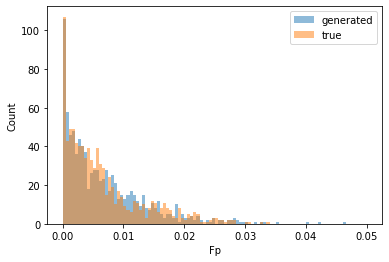

<Figure size 432x288 with 0 Axes>

In [24]:


def Fp_distribution(num):
    p = 0.1182
    params = (1.064799958220838, 0.0005001496965058328, 0.007151833882619035)
    start_nums = int(p*num)
    
    start = np.random.uniform(low = 0, high= 0.0005, size = start_nums)
    
    dist_num = num - start_nums
    gen_data_Fp = st.weibull_min.rvs(params[0], params[1], params[2], size=dist_num)
    gen_data_Fp = np.array(gen_data_Fp)
    
    true_dist = np.concatenate((gen_data_Fp, start), axis=None)
    print(true_dist.shape)
    #true_dist[true_dist > 1] = 0.99

    
    
    return true_dist
    
    
gen_dataFp = Fp_distribution(Fp_list_uterus.size)
print(gen_data.size, Fp_list_uterus.size)
plt.hist(gen_dataFp, bins = 100, alpha=0.5, label='generated', range=[0, 0.05])
plt.hist(Fp_list_uterus, alpha = 0.5, bins = 100, label = 'true', range=[0, 0.05])
plt.legend(loc='upper right')
plt.xlabel('Fp')
plt.ylabel('Count')
plt.savefig('plots/Fp_dist')
plt.show()
plt.clf()





In [9]:
vp_list_uterus_noend = vp_list_uterus[vp_list_uterus <= 0.97]
print(vp_list_uterus_noend.size)
best_dist, best_p, params = get_best_distribution(vp_list_uterus_noend)


645
p value for norm = 1.6611684693371523e-07
p value for exponweib = 1.0973250724938875e-97
p value for weibull_max = 0.0010547123332707664
p value for weibull_min = 3.6948179644828657e-06
p value for pareto = 2.983862928670769e-06
p value for genextreme = 0.0004979011042653114
p value for halfnorm = 1.4598328582009634e-07
Best fitting distribution: weibull_max
Best p value: 0.0010547123332707664
Parameters for the best fit: (29572479.030125827, 6450136.935704315, 6450136.715197781)


(905,)


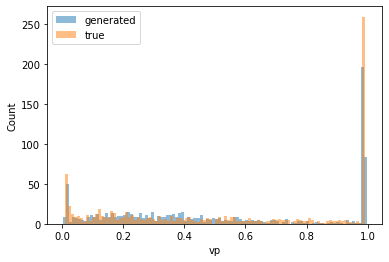

<Figure size 432x288 with 0 Axes>

In [32]:
def vp_distrubition(num):
    params = (29572479.030125827, 6450136.935704315, 6450136.715197781)
    p = 0.287
    endnum = int(p*num)
    end = np.random.uniform(low = 0.98, high= 0.99, size = endnum)
    
    dist_num = num - endnum
    gen_data_vp = st.weibull_max.rvs(params[0], params[1], params[2], size=dist_num)
    gen_data_vp = np.array(gen_data_vp)
    
    true_dist = np.concatenate((gen_data_vp, end), axis=None)
    print(true_dist.shape)
    true_dist[true_dist > 1] = 0.99
    true_dist[true_dist < 0] = 0.011

    
    
    return true_dist




dist = vp_distrubition(vp_list_uterus.size)

plt.hist(dist,alpha = 0.5, bins = 100, label = 'generated')
plt.hist(vp_list_uterus,alpha = 0.5, bins = 100, label = 'true')
plt.xlabel('vp')
plt.ylabel('Count')
plt.legend()
plt.savefig('plots/vp_dist')

plt.show()
plt.clf()

In [25]:
AIF = np.load("data/AIF.npy")
series = np.load("data/Example_Conc.npy")

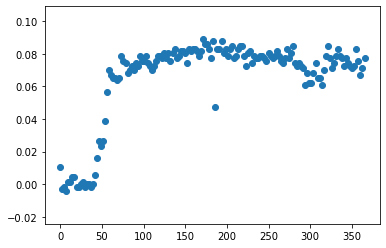

[0.04385121 0.0007764  0.04      ]


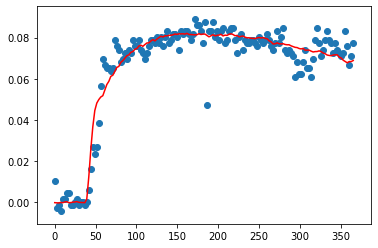

<Figure size 432x288 with 0 Axes>

In [33]:
i = 112
j = 80
k = 10
t = np.arange(0,366,2.45)


points = series[i,j,k,:]
plt.scatter(t, points)
plt.savefig('plots/scatter')
plt.show()
plt.clf()

fitted_param = TwoCUMfittingConc(t, AIF, series[i,j,k,:] , 0)
pk = fitted_param[:3]
print(pk)
predicted_curve = TwoCUM(pk, t, AIF, 0)
plt.plot(t, predicted_curve, color='red')
plt.scatter(t, points)
plt.savefig('plots/scatter_fitted')
plt.show()
plt.clf()

In [5]:
current_epoch_losses = {'a' : [1,2,3], 'b' : [3,3,3], 'c' : [2,2,2]}


out_string = "_".join(["{}_{:.4f}".format(key, np.mean(value)) for key, value in current_epoch_losses.items()])
print(out_string)

a_2.0000_b_3.0000_c_2.0000
